# Solution: Amoeba Classification

This is the solution for amoeba classification assignment. 

Here, we use the images that are collected from our lab to train our own custom model to classify the images if they contain amoeba or not. 


## Table of content

* Load images dataset
* Data preparation
* Build and train the model
* Evaluate the model
* Inference

# Load images dataset

The images dataset is loaded and we will use them to train our custom model. All of the images are collected in our lab.  

In [ ]:
# upload zip file of the dataset from local
from google.colab import files
uploaded = files.upload()
for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

!unzip dataset-amoebaClassification.zip

Saving dataset-amoebaClassification.zip to dataset-amoebaClassification.zip
User uploaded file "dataset-amoebaClassification.zip" with length 11471309 bytes
Archive:  dataset-amoebaClassification.zip
   creating: dataset-amoebaClassification/test/
   creating: dataset-amoebaClassification/test/amoeba/
  inflating: dataset-amoebaClassification/test/amoeba/a10.jpg  
  inflating: dataset-amoebaClassification/test/amoeba/a100.jpg  
  inflating: dataset-amoebaClassification/test/amoeba/a100copy.jpg  
  inflating: dataset-amoebaClassification/test/amoeba/a10copy.jpg  
  inflating: dataset-amoebaClassification/test/amoeba/a11.jpg  
  inflating: dataset-amoebaClassification/test/amoeba/a11copy.jpg  
  inflating: dataset-amoebaClassification/test/amoeba/a6.jpg  
  inflating: dataset-amoebaClassification/test/amoeba/a6copy.jpg  
  inflating: dataset-amoebaClassification/test/amoeba/a7.jpg  
  inflating: dataset-amoebaClassification/test/amoeba/a7copy.jpg  
  inflating: dataset-amoebaClassificati

In [ ]:
# download dataset from github

# %%shell
# git clone https://github.com/BaosenZ/amoeba-detection.git


# Data preparation

In this step, we will prepare dataset, including spliting training, validation and test dataset, and normalize dataset. We provide one method to prepare the dataset in here. More way to prepare the dataset can be found here: https://keras.io/examples/vision/image_classification_from_scratch/. 

In [ ]:
import os
import numpy as np
from tqdm import tqdm
from glob import glob
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

# training data preparation

# define image size, it can be modified 
img_size = 299
# training images dataset path
train_path = 'dataset-amoebaClassification/train' 
nub_train = len(glob(train_path + '/*/*.jpg'))
# Create empty array, fill out the image array to newly-created array. 
X_train = np.zeros((nub_train,img_size,img_size,3),dtype=np.uint8) 
y_train = np.zeros((nub_train,),dtype=np.uint8)

i = 0
for img_path in tqdm(glob(train_path + '/*/*.jpg')):
    # print(img_path)

    img = Image.open(img_path)
    # image resize
    img = img.resize((img_size,img_size)) 
    # images are converted to array
    arr = np.asarray(img)
    # assign array
    X_train[i, :, :, :] = arr
    
    if img_path.split('/')[-2] == 'amoeba':
        # Set amoeba class as 0
        y_train[i] = 0
    else:
        # Set no amoeba class as 1
        y_train[i] = 1
        
    i += 1

100%|██████████| 300/300 [00:11<00:00, 25.49it/s]


In [ ]:
# validation data preparation

# define image size, it can be modified 
img_size = 299
# validation images dataset path
validation_path = 'dataset-amoebaClassification/validation' 
nub_validation = len(glob(validation_path + '/*/*.jpg'))
# Creat empty array, fill out the image array to newly-created array. 
X_validation = np.zeros((nub_validation,img_size,img_size,3),dtype=np.uint8) 
y_validation = np.zeros((nub_validation,),dtype=np.uint8)

i = 0
for img_path in tqdm(glob(validation_path + '/*/*.jpg')):
    # print(img_path)

    img = Image.open(img_path)
    # image resize
    img = img.resize((img_size,img_size)) 
    # images are converted to array
    arr = np.asarray(img)
    # assign array
    X_validation[i, :, :, :] = arr
    
    if img_path.split('/')[-2] == 'amoeba':
        # Set cat class as 0
        y_validation[i] = 0
    else:
        # Set dog class as 1
        y_validation[i] = 1
        
    i += 1

100%|██████████| 68/68 [00:02<00:00, 22.93it/s]


In [ ]:
# test data preparation

img_size = 299
test_path = 'dataset-amoebaClassification/test'
nub_test = len(glob(test_path + '/*/*.jpg'))

X_test = np.zeros((nub_test,img_size,img_size,3),dtype=np.uint8) 
y_test = np.zeros((nub_test,),dtype=np.uint8)

i = 0
for img_path in tqdm(glob(test_path + '/*/*.jpg')):
    # print(img_path)

    img = Image.open(img_path)
    img = img.resize((img_size,img_size))
    arr = np.asarray(img)
    X_test[i, :, :, :] = arr
          
    if img_path.split('/')[-2] == 'amoeba':
        # Set cat class as 0
        y_test[i] = 0
    else:
        # Set dog class as 1
        y_test[i] = 1
        
    i += 1

100%|██████████| 57/57 [00:02<00:00, 23.83it/s]


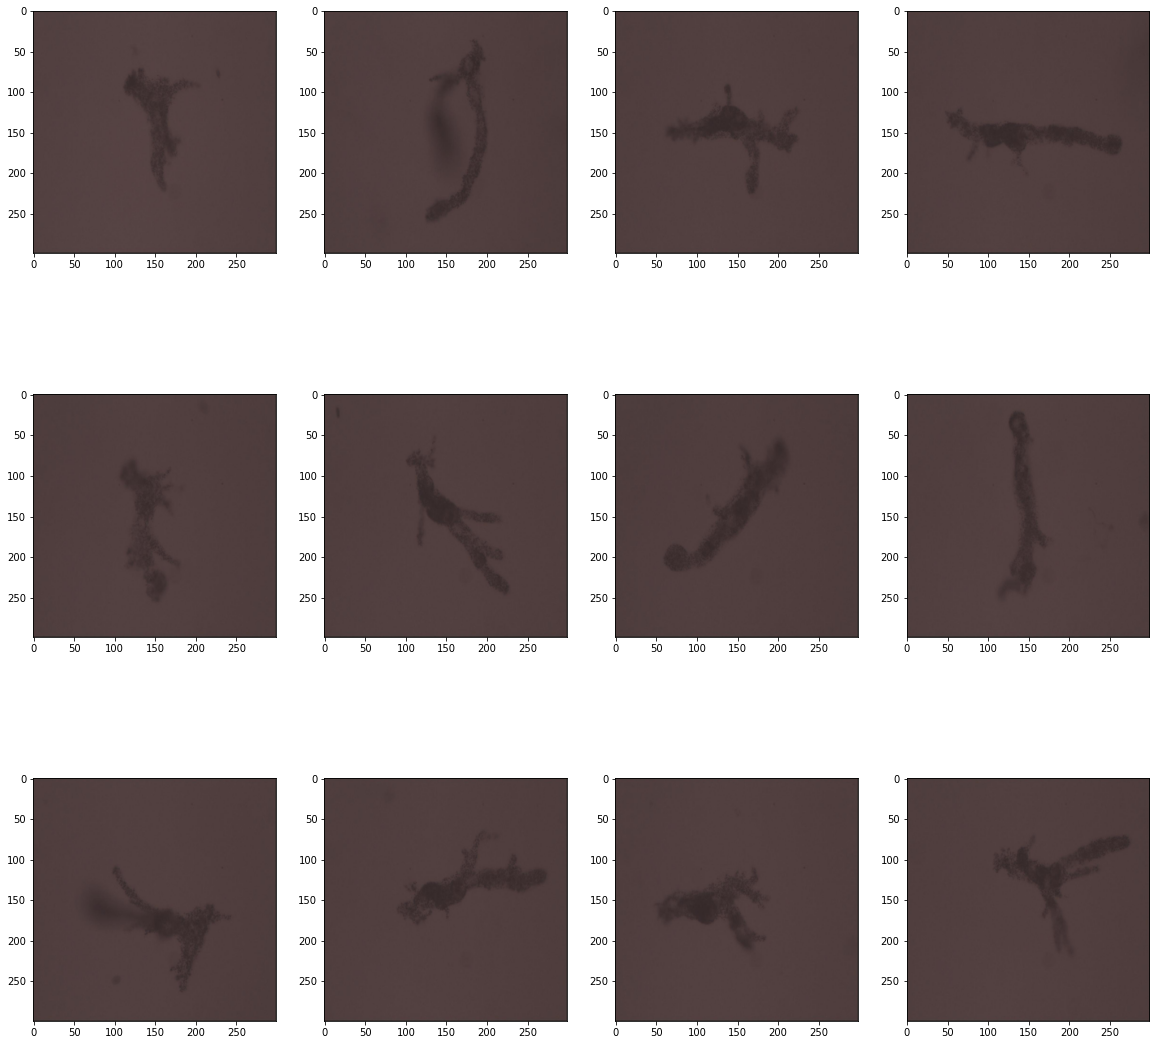

In [ ]:
# Visualize the training dataset
fig,axes = plt.subplots(3,4,figsize=(20, 20))

j = 0
for i,img in enumerate(X_train[:12]):
    axes[i//4,j%4].imshow(img)
    j+=1

In [ ]:
# normalize the dataset
X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train_norm = (X_train - X_mean) / X_std
X_validation_norm = (X_validation - X_mean) / X_std
X_test_norm = (X_test - X_mean) / X_std

X_train_norm = X_train_norm[..., np.newaxis]
X_validation_norm = X_validation_norm[..., np.newaxis]
X_test_norm = X_test_norm[..., np.newaxis]

# Build and train the model

Simple convolustional neural network (CNN) is used to train the model. 

In [ ]:
# Build the model (sequential CNN model)
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([                           
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[299, 299, 3]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=32, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=16, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=2, activation='softmax'),
])

In [ ]:
# Compile the model
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

In [ ]:
# Train the model
history = model.fit(X_train_norm, y_train, epochs=10, validation_data=(X_validation_norm, y_validation))

Epoch 1/10
10/10 [==============================] - 414s 41s/step - loss: 2.9269 - accuracy: 0.6267 - val_loss: 0.4882 - val_accuracy: 1.0000
Epoch 2/10
10/10 [==============================] - 408s 41s/step - loss: 0.5505 - accuracy: 0.8000 - val_loss: 0.3654 - val_accuracy: 0.9559
Epoch 3/10
10/10 [==============================] - 408s 41s/step - loss: 0.5140 - accuracy: 0.7533 - val_loss: 0.3518 - val_accuracy: 0.9559
Epoch 4/10
10/10 [==============================] - 420s 42s/step - loss: 0.5085 - accuracy: 0.8967 - val_loss: 0.3649 - val_accuracy: 0.9706
Epoch 5/10
10/10 [==============================] - 423s 42s/step - loss: 0.4110 - accuracy: 0.9000 - val_loss: 0.3148 - val_accuracy: 0.9559
Epoch 6/10
10/10 [==============================] - 412s 41s/step - loss: 0.3777 - accuracy: 0.9200 - val_loss: 0.3247 - val_accuracy: 0.9559
Epoch 7/10
10/10 [==============================] - 408s 41s/step - loss: 0.4567 - accuracy: 0.9200 - val_loss: 0.2747 - val_accuracy: 1.0000
Epoch 

# Evaluate the model

In [ ]:
# visualize the model structure with model.summary(). Feel free to comment out the code below to visualize the model structure

# model.summary()

The test dataset is not used for training and validation, which means they are new to the trained model. And we will use it to get the performance of the model. The performance is acceptable because the accuracy for test dataset is nearly the same with accuracy for train and validation dataset.

In [ ]:
# Using test dataset to evaluate loss and accuracy for trained model
results = model.evaluate(X_test_norm, y_test, batch_size=128)

1/1 [==============================] - 22s 22s/step - loss: 0.2592 - accuracy: 1.0000


At the end of epoch, the accuary for training and validation dataset should be close. This is a easy way to determine if there is overfitting or not. 

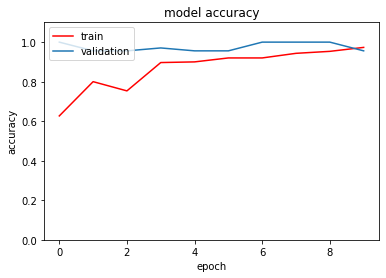

In [ ]:
# plot accuracy vs epoch
plt.plot(history.history['accuracy'],'r')
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left') 
plt.ylim([0, 1.1])
plt.show()

# Inference

We visualize the image and use your judgement to see if there is amoeba exist in the image and then compare it with the model prediction.
:

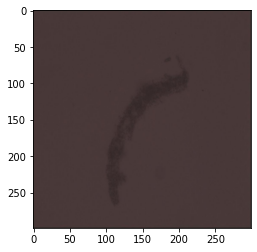

In [ ]:
from keras.applications.imagenet_utils import decode_predictions
import matplotlib.pyplot as plt
from keras.preprocessing import image
import numpy as np

# Visualize one image, X_test[x]. Here we choose X_test[1]. You can choose any of the images among all test dataset
img1 = X_test[1]
plt.imshow(img1)


we will predict the image above with model.predict() function to see if it matches with your judgement. 

In [ ]:
# class label
class_label = ['amoeba exist', 'no amoeba exist']

# image process
x = np.squeeze(X_test_norm[1])
x = image.img_to_array(x)
x = np.expand_dims(x, axis=0)

# predict the image with model.predict()
y_prob = model.predict(x)
print("probality for each of the catogaries: ", y_prob)
y_class = y_prob.argmax(axis=-1)
print("model predict: ", class_label[y_class[0]])

probality for each of the catogaries:  [[1.0000000e+00 3.6666708e-11]]
model predict:  amoeba exist
